In [ ]:
%%capture
!pip install diffusers[training]
!pip install transformers
!pip install datasets
!pip install "git+https://github.com/broutonlab/deep-learning-course.git"

import dl_course.diffusers.utils as courseutils

# Introduction to Diffusion models

You've probably already heard about [DALL-E 2](https://openai.com/dall-e-2/).  
This is a model that achieves astonisting results in solving the Text-to-Image task.  
The quality of images produced from captions really shows the power of **diffusion models**.  

Bad news: DALL-E 2 is not available for us to play with.  
More bad news: good Text-to-Image models are so heavy that the free version of Colab is barely enough to even fine-tune them.  
Good news: we'll still be training a diffusion model, but a modest one. 

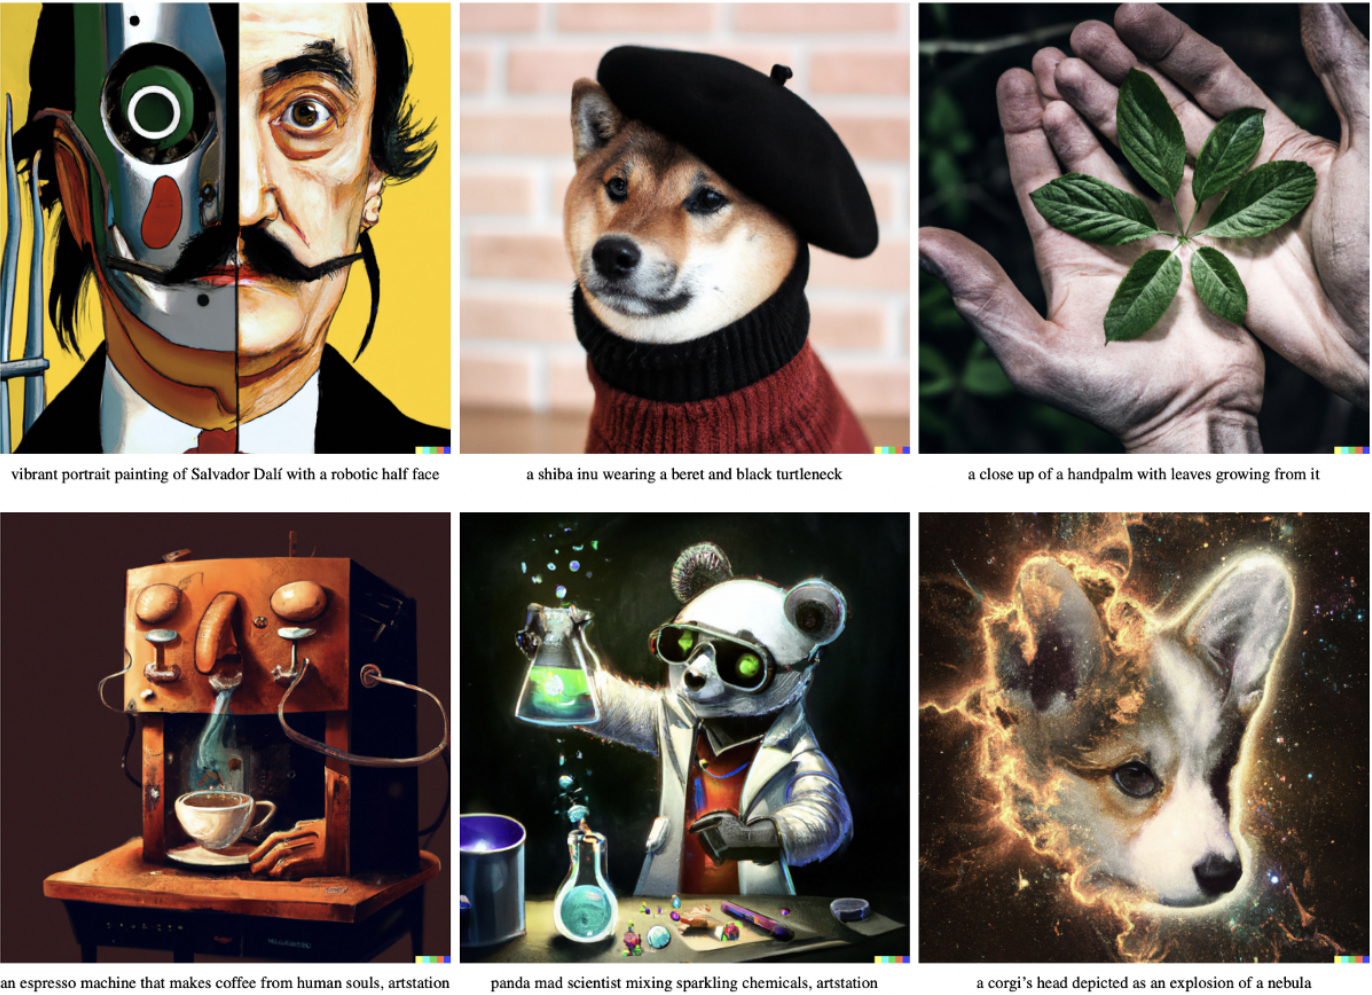

Diffusion models are often used in these tasks:


*   Image generation
*   Video generation
*   Audio synthesis (Text-to-Speech, etc.)
*   and others...



# How diffusion works

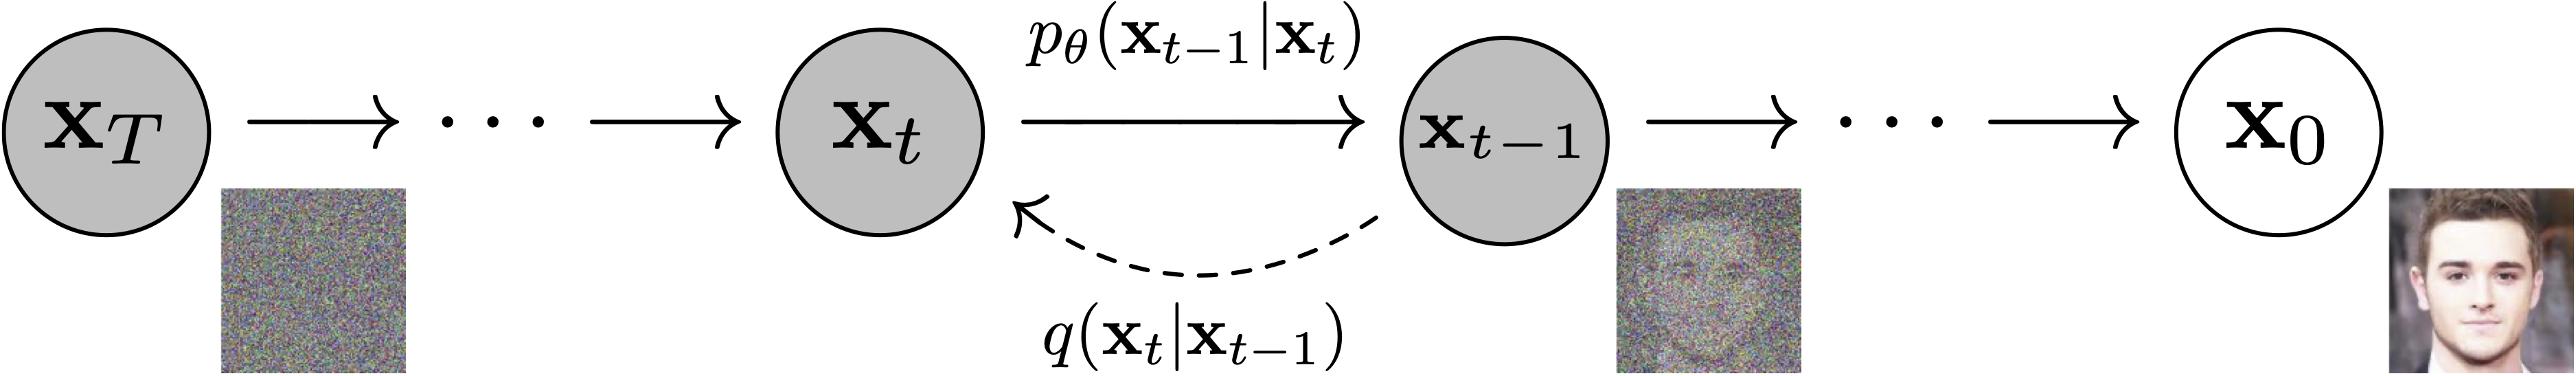

You'll probably see the picture above a lot when researching diffusion.  

Diffusion models and **really simple**:  
Imagine you want to generate images of a specific type (e.g. make a face generator like https://thispersondoesnotexist.com/). You have a dataset of images like the ones you want to generate. Here's what you do:


1.   You start with an image on the right ($x_0$).
2.   You apply a bit of noise to it. You do it $t$ times. Now you have $x_t$.
3.   Now you train your model to denoise the image a bit (you feed $x_t$ to the model and compare the model's output with $x_{t-1}$).
4.   Good news! You model can now reverse the noise 1 step at a time! Run it iteratively and you can denoise a pretty noisy image.
5.   Now generate a completely new image entirely consisting of noise ($x_T$) 🤯. Feed it to your model. It has no other choice but to generate an image like those you've fed it on the training phase. Magic!

We can condition our model with text labels to generate images from captions.


# The idea: autoencoders

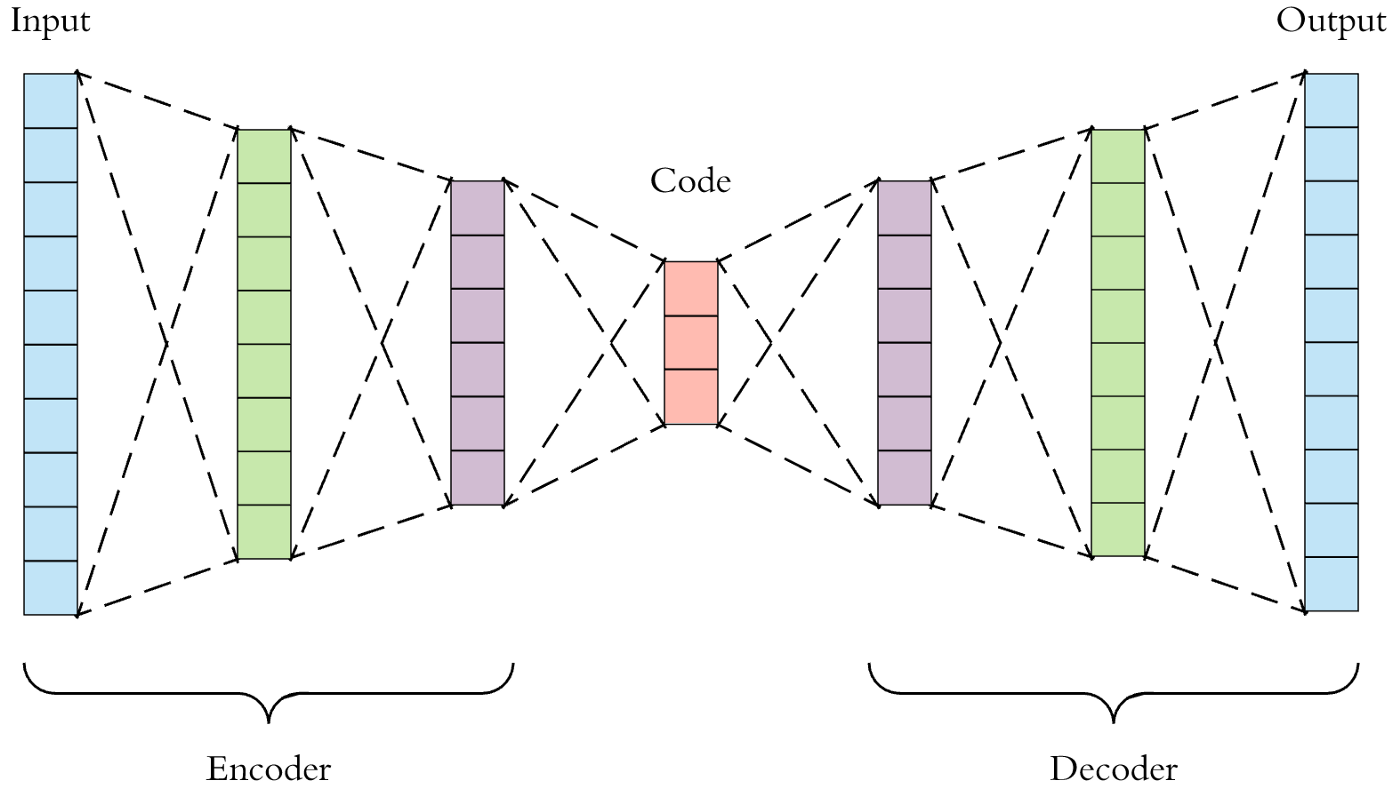

One of the ways to denoise images is the **Autoencoder** architecture.  
The idea is pretty simple: you have a network called **Encoder** that scales the input down to a lower dimension (moves it into a so-called **latent space** or **code space**), condensing the important information into a more compact representation.  
Then the **Decoder** network then expands the **latent representation** back into the original space.

You can train autoencoders **end-to-end**, meaning you train both Encoder and Decoder at the same time.

It's easy to see how to this can be used to denoise images: you pass a noisy image as an input and expect a denoised image as an output.

Although autoencoders can denoise, they are often used when code space actually matters (in a diffusion model we care only about the output). Autoencoders perform poorly when we need the same model to handle different levels of noise. More on that: https://benanne.github.io/2022/01/31/diffusion.html

# The idea: U-Net

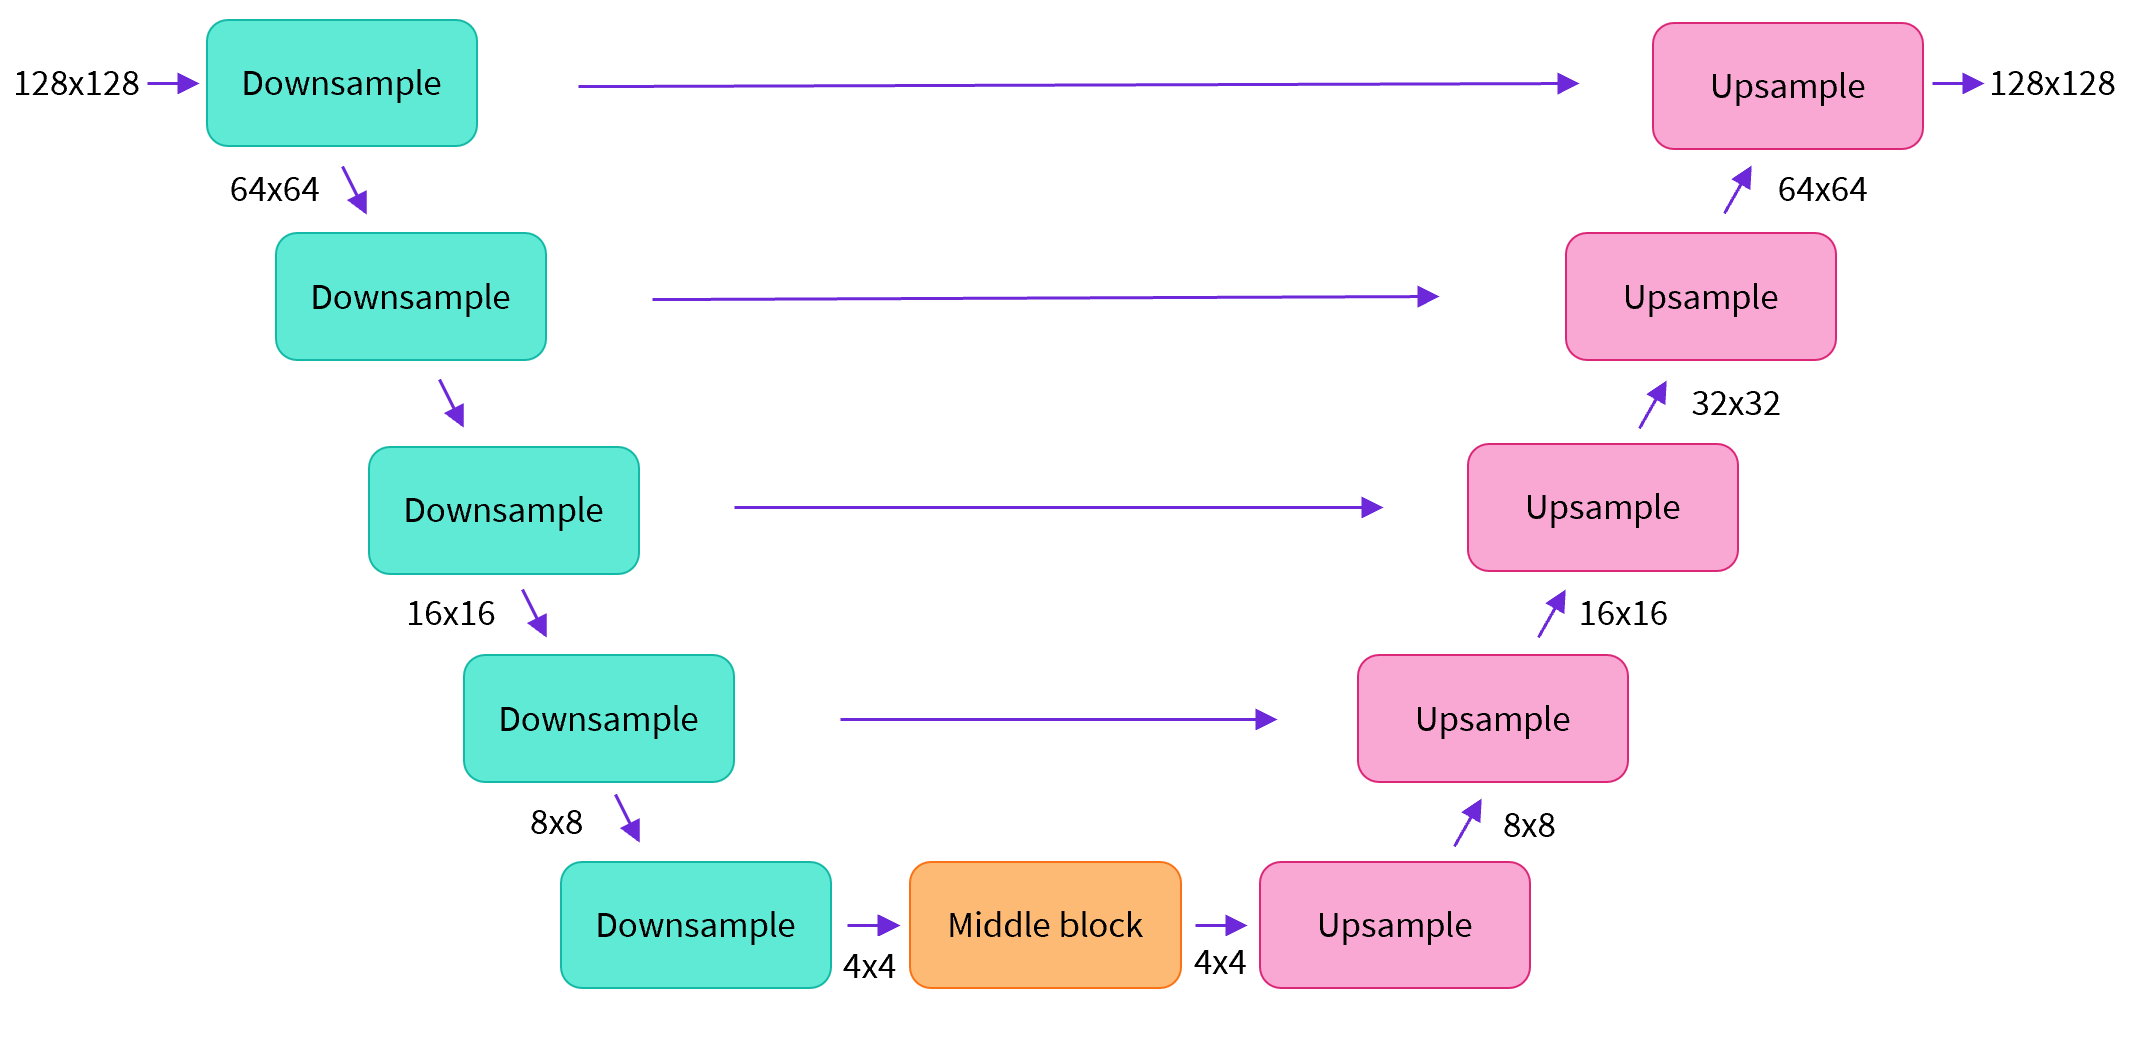

**U-Nets** are similar to autoencoders (we scale things up and down), but they aren't autoencoders by definition.

What makes them different from autoencoders are the **skip connections** (also called **residual connections**) between different levels.  
Skip connections are often used to get rid of bottlenecks and vanishing gradients. More on that here: https://theaisummer.com/skip-connections/.  
This is a very important topic, skip connections made a revolution some time ago and nowadays are ubiquitous.

# Enough talking!

In [ ]:
from dataclasses import dataclass
# it's a good practice to keep all of your hyperparameters in the same place

@dataclass
class TrainingConfig:
    image_size = 64
    train_batch_size = 32
    preview_images = 16 # how many images to preview
    gradient_accumulation_steps = 1 # https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation
    mixed_precision = 'fp16'  # https://huggingface.co/docs/transformers/v4.13.0/en/performance
    num_epochs = 30
    learning_rate = 1e-4
    lr_warmup_steps = 500
    preview_image_epochs = 10 # generate preview images each N epochs
    save_model_epochs = 10
    preview_size_factor = 2 # upscaling factor for preview
    output_dir = 'my_model'
    seed = 0

config = TrainingConfig()

In [ ]:
from diffusers import UNet2DModel

# create the U-net!
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 256, 256, 512, 512),  # the number of output channels for each block below
    down_block_types=( 
        # define the actual architecture. 
        # Each DownBlock2D reduces the size along each axis by 2 
        # (i.e. 1/4 of the total number of pixels).
        # Each UpBlock2D does the opposite.
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        # [!] TODO: complete the architecture with more blocks so that
        # output dimensions match input dimensions.
        ...
      ),
)

Check if model output dimensions are the same as input dimensions:

In [ ]:
import torch
import numpy as np

dummy_image_batch = torch.Tensor(np.zeros((1, 3, config.image_size, config.image_size)))
print(f'Test batch shape: {dummy_image_batch.shape}')
print(f'Output batch shape: {model(dummy_image_batch, timestep=0).sample.shape}')
print(f"If the dimensions aren't equal, change the UNet architecture!")

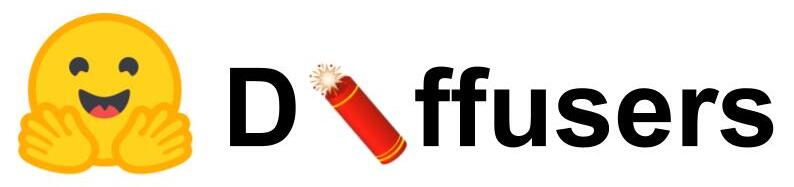

Actually, what makes this notebook possible is the [Diffusers](https://github.com/huggingface/diffusers) library.  
They make diffusion models easy to use and configure. Feel free to explore their notebooks as well! (if you're feeling adventurous, you can try [adding new concepts to Text-to-Image models](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb), maybe even using YOUR OWN pictures!)

# Download the dataset

We're using [Datasets](https://huggingface.co/docs/datasets/index) again.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split='train')

In [ ]:
dataset

# Add augmentations and resize images

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# a nice function provided by Huggingface. More about dataset processing: https://huggingface.co/docs/datasets/process
dataset.set_transform(transform)

Preview the dataset after the changes:

In [ ]:
courseutils.preview_transformed_dataset(dataset, "images")

In [ ]:
import torch
from diffusers.optimization import get_cosine_schedule_with_warmup


# make a dataloader as always
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

# configure an optimizer as always
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# Learning rate scheduler is a tool that varies learning rate with time.
# Pytorch has its own schedulers: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
# When training a lot of epoch, a scheduler is almost a must-have.
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Noise schedulers

Noise schedulers take care of applying noise to images.
There are different algorithms that require different types of noise.

In [ ]:
from diffusers import DDPMScheduler

# we're using 1000 denoising iterations.
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Training loop

In [ ]:
from accelerate import Accelerator
import torch.nn.functional as F
from diffusers import DDPMPipeline
from tqdm.auto import tqdm
import os
import math

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
    )

    if accelerator.is_main_process:
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with preview_pipeline() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.preview_image_epochs == 0 or epoch == config.num_epochs - 1:
                courseutils.preview_pipeline(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

Let's train!

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

# Home task


*   So far we've been skipping one the important aspects of developing an AI model: working with data. Your task will be to find any dataset of your liking on the internet (you can use https://huggingface.co/datasets) and make it work with our model.  
You can try working with images of smaller size to reduce training time. Remember that you need to make changes to your U-Net architecture as well.  
[!] Choose carefully, you need a dataset of a very narrow and simple category of objects, because otherwise you'll have to spend a lot of time training.  
[!] You may want to add more augmentations if your dataset is too small. 
*   Implement an **Autoencoder** and compare its performance with U-Net. 
Your knowledge of CNNs and Pytorch should be enough to make an autoencoder from scratch, but feel free to look it up on the web.
*   Save your model for future use outside of this notebook (refer to [this](https://huggingface.co/docs/transformers/model_sharing) or [this](https://huggingface.co/docs/hub/models-uploading) or use whatever you find convenient).

